# Group 9
- Zhixin Zeng
- Yichen Wang
- Mingyi Ni
- Zixiang Hu

## Thesis: Greater access to the internet leads to higher economic growth.

### Data used:
1. Individuals using the Internet (% of population) [link](https://data.worldbank.org/indicator/IT.NET.USER.ZS)
2. GDP growth (annual %) [link](https://data.worldbank.org/indicator/NY.GDP.MKTP.KD.ZG)


In [36]:
!python -m pip install "pymongo[srv]"

Looking in indexes: https://pypi.python.org/simple/


# Connect DB

In [37]:
username="crimson725"
password="13678422587"
cluster_address="cluster0.1nh21id.mongodb.net"
uri = f"mongodb+srv://{username}:{password}@{cluster_address}/?retryWrites=true&w=majority&appName=Cluster0"

In [38]:
from pymongo.mongo_client import MongoClient
from pymongo.server_api import ServerApi

client = MongoClient(uri, server_api=ServerApi('1'))

try:
    client.admin.command('ping')
    print("Pinged your deployment. You successfully connected to MongoDB!")
except Exception as e:
    print(e)

Pinged your deployment. You successfully connected to MongoDB!


In [39]:
db=client['Proj3']
# the two collections are 'gdp_growth' and 'internet_penetration_rates'

# Import the data

In [40]:
import pandas as pd
gdp_growth = pd.read_csv('gdp_growth.csv')
internet_penetration_rates = pd.read_csv('Individuals_using_internet.csv')

if "gdp_growth" in db.list_collection_names():
    db.drop_collection('gdp_growth')
if "internet_penetration_rates" in db.list_collection_names():
    db.drop_collection('internet_penetration_rates')

gdp_collection=db['gdp_growth']
internet_collection=db['internet_penetration_rates']
gdp_growth.fillna(0, inplace=True)
internet_penetration_rates.fillna(0, inplace=True)


In [41]:
# Do some conversion
gdp_growth['Country Name'] = gdp_growth['Country Name'].astype(str)
gdp_growth['Country Code'] = gdp_growth['Country Code'].astype(str)
gdp_growth['Indicator Name'] = gdp_growth['Indicator Name'].astype(str)
internet_penetration_rates['Country Name'] = internet_penetration_rates['Country Name'].astype(str)
internet_penetration_rates['Country Code'] = internet_penetration_rates['Country Code'].astype(str)
internet_penetration_rates['Indicator Name'] = internet_penetration_rates['Indicator Name'].astype(str)


In [42]:
# Import into MongoDB
gdp_collection.insert_many(gdp_growth.to_dict('records'))
internet_collection.insert_many(internet_penetration_rates.to_dict('records'))

InsertManyResult([ObjectId('661ec56cf79368f710658154'), ObjectId('661ec56cf79368f710658155'), ObjectId('661ec56cf79368f710658156'), ObjectId('661ec56cf79368f710658157'), ObjectId('661ec56cf79368f710658158'), ObjectId('661ec56cf79368f710658159'), ObjectId('661ec56cf79368f71065815a'), ObjectId('661ec56cf79368f71065815b'), ObjectId('661ec56cf79368f71065815c'), ObjectId('661ec56cf79368f71065815d'), ObjectId('661ec56cf79368f71065815e'), ObjectId('661ec56cf79368f71065815f'), ObjectId('661ec56cf79368f710658160'), ObjectId('661ec56cf79368f710658161'), ObjectId('661ec56cf79368f710658162'), ObjectId('661ec56cf79368f710658163'), ObjectId('661ec56cf79368f710658164'), ObjectId('661ec56cf79368f710658165'), ObjectId('661ec56cf79368f710658166'), ObjectId('661ec56cf79368f710658167'), ObjectId('661ec56cf79368f710658168'), ObjectId('661ec56cf79368f710658169'), ObjectId('661ec56cf79368f71065816a'), ObjectId('661ec56cf79368f71065816b'), ObjectId('661ec56cf79368f71065816c'), ObjectId('661ec56cf79368f7106581

# Inspect the data

In [43]:
from pprint import pprint

pprint(db.gdp_growth.find_one())  
pprint(db.internet_penetration_rates.find_one())  

{'1960': 0.0,
 '1961': 0.0,
 '1962': 0.0,
 '1963': 0.0,
 '1964': 0.0,
 '1965': 0.0,
 '1966': 0.0,
 '1967': 0.0,
 '1968': 0.0,
 '1969': 0.0,
 '1970': 0.0,
 '1971': 0.0,
 '1972': 0.0,
 '1973': 0.0,
 '1974': 0.0,
 '1975': 0.0,
 '1976': 0.0,
 '1977': 0.0,
 '1978': 0.0,
 '1979': 0.0,
 '1980': 0.0,
 '1981': 0.0,
 '1982': 0.0,
 '1983': 0.0,
 '1984': 0.0,
 '1985': 0.0,
 '1986': 0.0,
 '1987': 16.07843137,
 '1988': 18.64864865,
 '1989': 12.12984055,
 '1990': 3.961401727,
 '1991': 7.962871744,
 '1992': 5.882353953,
 '1993': 7.307693245,
 '1994': 8.203901293,
 '1995': 2.547143687,
 '1996': 1.185788511,
 '1997': 7.046874992,
 '1998': 1.991984449,
 '1999': 1.238041842,
 '2000': 7.622920639,
 '2001': 4.182002641,
 '2002': -0.944954681,
 '2003': 1.11050501,
 '2004': 7.29372894,
 '2005': -0.383139604,
 '2006': 1.127412128,
 '2007': 3.089543901,
 '2008': 1.835755679,
 '2009': -11.67774203,
 '2010': -2.733455707,
 '2011': 3.369238122,
 '2012': -1.040800135,
 '2013': 6.431481824,
 '2014': -1.586574644,
 '

# Check if there is missing data

In [44]:
# Count documents with missing 'Country Code' in the 'gdp_growth' collection
missing_country_gdp_count = db.gdp_growth.count_documents({"$or": [{"Country Code": {"$exists": False}}, {"Country Code": None}]})
missing_country_internet_count = db.internet_penetration_rates.count_documents({"$or": [{"Country Code": {"$exists": False}}, {"Country Code": None}]})

print("Missing country codes in GDP Growth:", missing_country_gdp_count)
print("Missing country codes in Internet Penetration:", missing_country_internet_count)

Missing country codes in GDP Growth: 0
Missing country codes in Internet Penetration: 0


# Handling Zeroes for Internet Penetration Rate

In [45]:
pipeline = [
    {
        "$project": {
            "data": {
                "$objectToArray": "$$ROOT"
            }
        }
    },
    {
        "$unwind": "$data"
    },
    {
        "$match": {
            "data.k": {
                "$regex": "^\d{4}$"
            }
        }
    },
    {
        "$addFields": {
            "data.v": {
                "$cond": [
                    {"$eq": ["$data.v", 0]},  # Check for 0 and replace
                    "$$REMOVE",  # Remove elements that are 0
                    "$data.v"
                ]
            }
        }
    },
    {
        "$group": {
            "_id": "$data.k",
            "values": {
                "$push": "$data.v"
            }
        }
    },
    {
        "$addFields": {
            "count": {"$size": "$values"},
            "midIndex": {"$floor": {"$divide": [{"$size": "$values"}, 2]}}
        }
    },
    {
        "$addFields": {
            "valuesSorted": {"$sortArray": {"input": "$values", "sortBy": {"$const": 1}}}
        }
    },
    {
        "$addFields": {
            "median": {
                "$cond": {
                    "if": {"$eq": [{"$mod": ["$count", 2]}, 0]},  # Check if count is even
                    "then": {  # If even, average middle two values
                        "$avg": [
                            {"$arrayElemAt": ["$valuesSorted", "$midIndex"]},
                            {"$arrayElemAt": ["$valuesSorted", {"$subtract": ["$midIndex", 1]}]}
                        ]
                    },
                    "else": {  # If odd, take the middle value
                        "$arrayElemAt": ["$valuesSorted", "$midIndex"]
                    }
                }
            }
        }
    },
    {
        "$project": {
            "medianRate": "$median"
        }
    }
]

# Execute the aggregation pipeline
yearly_medians = list(db.internet_penetration_rates.aggregate(pipeline))
yearly_medians_dict = {item['_id']: item['medianRate'] for item in yearly_medians}

In [46]:
# insert the calculated data
for year,median_value in yearly_medians_dict.items():
    update_result = db.internet_penetration_rates.update_many(
        {year: {"$eq": 0}},
        {"$set": {year: median_value}}
    )

# Handling zeroes for GDP growth

In [47]:
pipeline = [
    {
        "$project": {
            "Country Code": 1,
            "data": {"$objectToArray": "$$ROOT"}
        }
    },
    {
        "$unwind": "$data"
    },
    {
        "$match": {
            "data.k": {"$regex": "^\d{4}$"}
        }
    },
    {
        "$group": {
            "_id": "$data.k",
            "values": {"$push": "$data.v"}
        }
    },
    {
        "$addFields": {
            "count": {"$size": "$values"},
            "midIndex": {"$floor": {"$divide": [{"$size": "$values"}, 2]}}
        }
    },
    {
        "$addFields": {
            "valuesSorted": {"$sortArray": {"input": "$values", "sortBy": {"$const": 1}}}
        }
    },
    {
        "$addFields": {
            "median": {
                "$cond": {
                    "if": {"$eq": [{"$mod": ["$count", 2]}, 0]},  # Check if count is even
                    "then": {  # If even, average middle two values
                        "$avg": [
                            {"$arrayElemAt": ["$valuesSorted", "$midIndex"]},
                            {"$arrayElemAt": ["$valuesSorted", {"$subtract": ["$midIndex", 1]}]}
                        ]
                    },
                    "else": {  # If odd, take the middle value
                        "$arrayElemAt": ["$valuesSorted", "$midIndex"]
                    }
                }
            }
        }
    },
    {
        "$project": {
            "medianGDP": "$median"
        }
    },
    {
        "$sort": {"_id": 1}
    }
]

# Execute the aggregation pipeline
yearly_medians = list(db.gdp_growth.aggregate(pipeline))
yearly_medians_dict = {item['_id']: item['medianGDP'] for item in yearly_medians}

In [48]:
# Update the missing data
for year, median in yearly_medians_dict.items():
    query = {year: 0}
    update = {"$set": {year: median}}
    db.gdp_growth.update_many(query, update)

# Handling Outliers

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats

In [50]:
internet_data = list(db.internet_penetration_rates.find())
gdp_data = list(db.gdp_growth.find())

# Convert to Pandas DataFrames
df_internet = pd.DataFrame(internet_data)
df_gdp = pd.DataFrame(gdp_data)

# Reshape the dataframes to long format using pd.melt
df_internet_melted = df_internet.melt(id_vars=['Country Name', 'Country Code', '_id'], var_name='Year', value_name='Internet Penetration Rate')
df_gdp_melted = df_gdp.melt(id_vars=['Country Name', 'Country Code', '_id'], var_name='Year', value_name='GDP Growth')

# Convert 'Year' to numeric
df_internet_melted['Year'] = pd.to_numeric(df_internet_melted['Year'], errors='coerce')
df_gdp_melted['Year'] = pd.to_numeric(df_gdp_melted['Year'], errors='coerce')

# Merge the DataFrames on 'Country Code' and 'Year'
df_merged = pd.merge(df_internet_melted, df_gdp_melted, on=['Country Code', 'Year'])
df_merged.dropna(inplace=True)  # Drop rows with missing values

In [51]:
# Calculate the IQR for numeric columns only
Q1 = df_merged[['Internet Penetration Rate', 'GDP Growth']].quantile(0.25)
Q3 = df_merged[['Internet Penetration Rate', 'GDP Growth']].quantile(0.75)
IQR = Q3 - Q1

multiplier=2.5
outliers = ((df_merged[['Internet Penetration Rate', 'GDP Growth']] < (Q1 - multiplier * IQR)) |
            (df_merged[['Internet Penetration Rate', 'GDP Growth']] > (Q3 + multiplier * IQR)))
is_outlier = outliers.any(axis=1)
df_outliers = df_merged[is_outlier]
non_outliers = ~outliers.any(axis=1)


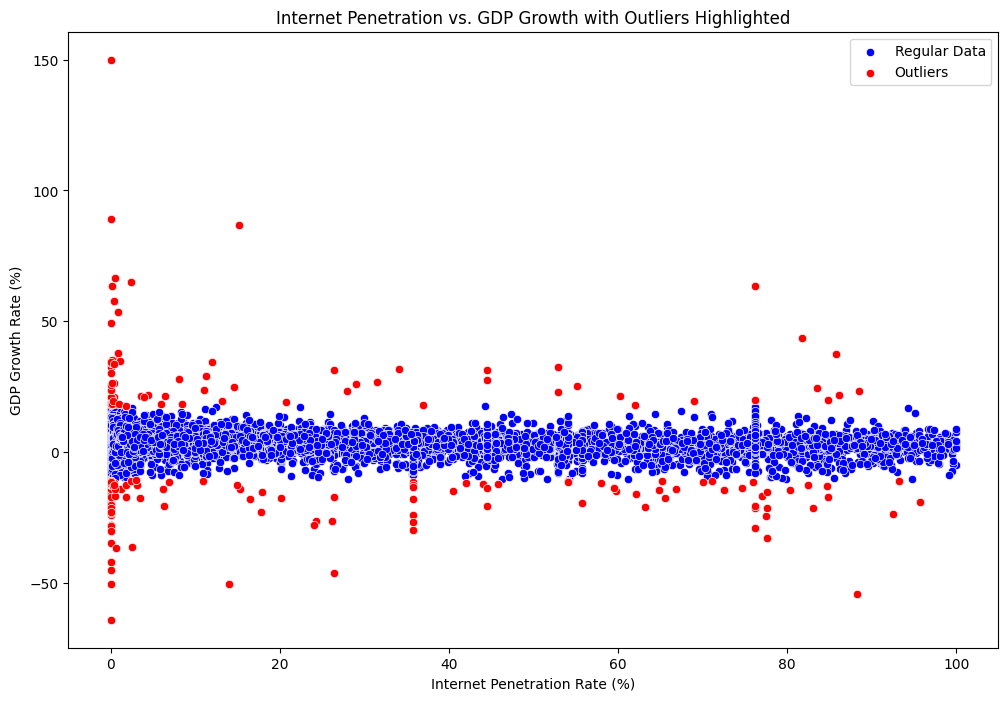

In [52]:
plt.figure(figsize=(12, 8))
sns.scatterplot(data=df_merged, x='Internet Penetration Rate', y='GDP Growth', color='blue', label='Regular Data')
sns.scatterplot(data=df_outliers, x='Internet Penetration Rate', y='GDP Growth', color='red', label='Outliers')
plt.title('Internet Penetration vs. GDP Growth with Outliers Highlighted')
plt.xlabel('Internet Penetration Rate (%)')
plt.ylabel('GDP Growth Rate (%)')
plt.legend()
plt.show()

In [53]:
# Remove the outliers
# Filter out outliers to create a new DataFrame
df_cleaned = df_merged[non_outliers]

# Check the shape of the original vs cleaned data
print("Original DataFrame shape:", df_merged.shape)
print("Cleaned DataFrame shape:", df_cleaned.shape)

Original DataFrame shape: (8778, 8)
Cleaned DataFrame shape: (8582, 8)


In [54]:
df_before1990=df_cleaned[df_cleaned['Year']<1990]
df_after1990=df_cleaned[df_cleaned['Year']>=1990]

# Analysis of the thesis after the year 1990

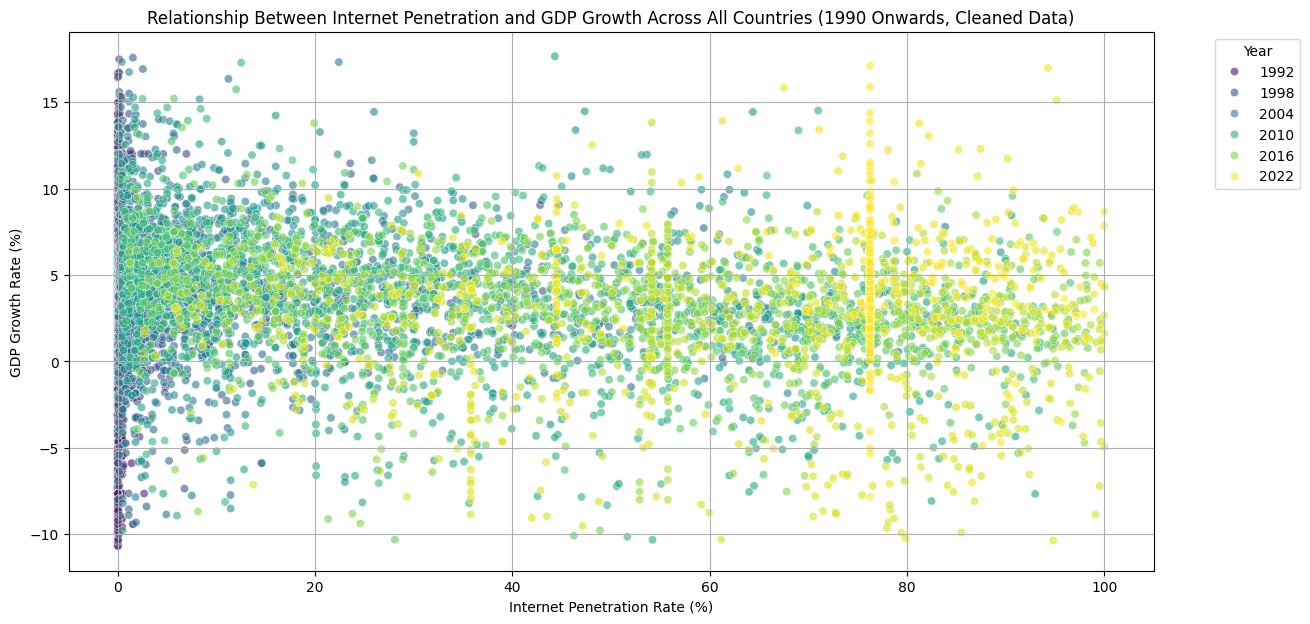

In [55]:
plt.figure(figsize=(14, 7))
sns.scatterplot(data=df_after1990, x='Internet Penetration Rate', y='GDP Growth', hue='Year', palette='viridis', alpha=0.6)
plt.title('Relationship Between Internet Penetration and GDP Growth Across All Countries (1990 Onwards, Cleaned Data)')
plt.xlabel('Internet Penetration Rate (%)')
plt.ylabel('GDP Growth Rate (%)')
plt.legend(title='Year', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()

# Correlation Analysis

In [56]:
# Calculate Pearson correlation coefficient
correlation, p_value = scipy.stats.pearsonr(df_after1990['Internet Penetration Rate'], df_after1990['GDP Growth'])
print(f"Correlation coefficient: {correlation}")
print(f"P-value: {p_value}")

Correlation coefficient: -0.12382455817145965
P-value: 1.1260194911685672e-30


# Regression Analysis

In [57]:
import statsmodels.api as sm


df_after1990['Internet Penetration Rate'] = pd.to_numeric(df_after1990['Internet Penetration Rate'], errors='coerce')
df_after1990['GDP Growth'] = pd.to_numeric(df_after1990['GDP Growth'], errors='coerce')
df_after1990 = df_after1990.dropna(subset=['Internet Penetration Rate', 'GDP Growth'])

# Prepare data for regression analysis
X = sm.add_constant(df_after1990['Internet Penetration Rate'])
Y = df_after1990['GDP Growth']

model = sm.OLS(Y, X).fit()  # Fit a regression model
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             GDP Growth   R-squared:                       0.015
Model:                            OLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     133.6
Date:                Tue, 16 Apr 2024   Prob (F-statistic):           1.13e-30
Time:                        11:37:57   Log-Likelihood:                -23964.
No. Observations:                8582   AIC:                         4.793e+04
Df Residuals:                    8580   BIC:                         4.795e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

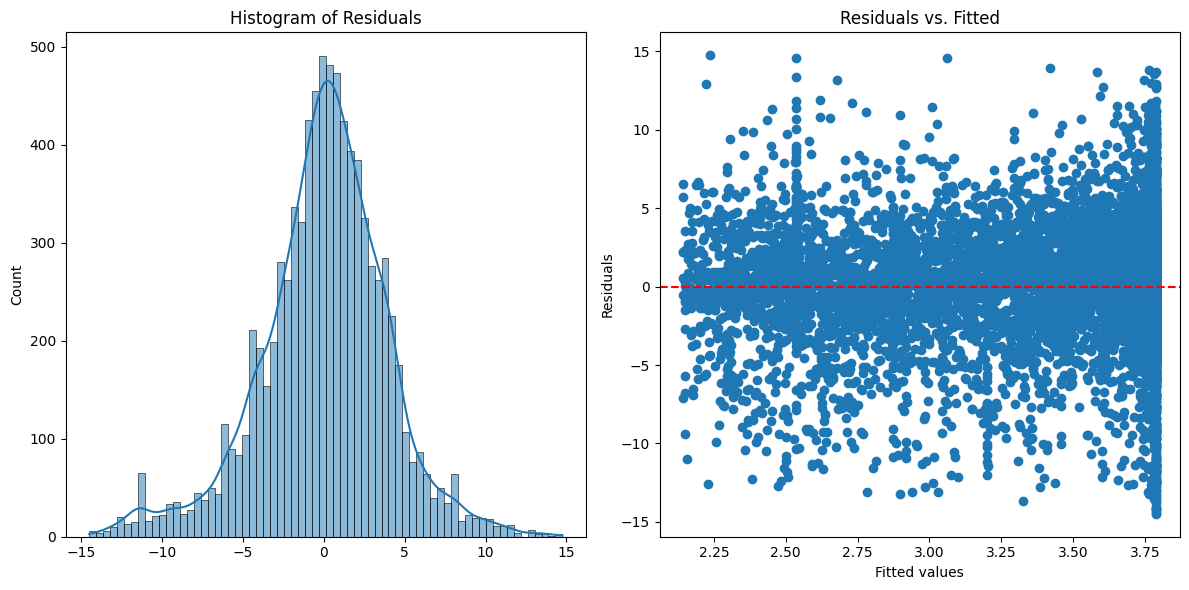

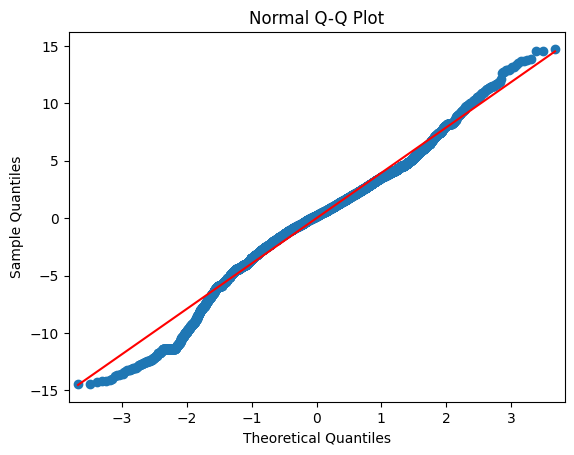

In [58]:
X = sm.add_constant(df_after1990['Internet Penetration Rate'])  # Add a constant term
Y = df_after1990['GDP Growth']
model = sm.OLS(Y, X).fit()

# Plotting residuals to check for normality and homoscedasticity
residuals = model.resid
fitted = model.fittedvalues

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(residuals, kde=True)
plt.title('Histogram of Residuals')

plt.subplot(1, 2, 2)
plt.scatter(fitted, residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Fitted')
plt.tight_layout()
plt.show()

# Q-Q plot for normality
fig = sm.qqplot(residuals, line='s')
plt.title("Normal Q-Q Plot")
plt.show()

# Cluster analysis

In [59]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Selecting the features for clustering
X = df_after1990[['Internet Penetration Rate', 'GDP Growth']]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)  # Normalizing the data

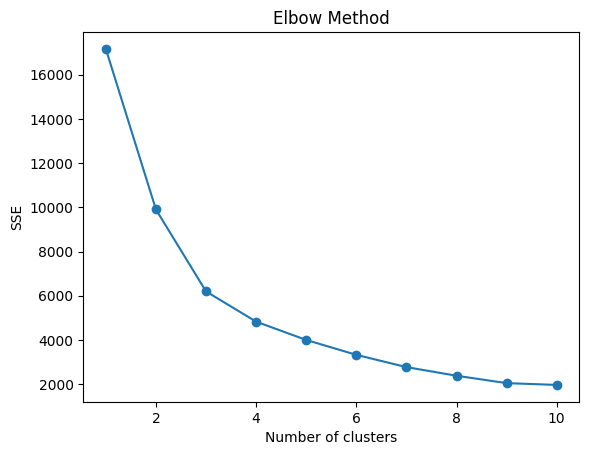

In [60]:
# Elbow method to determine the optimal number of clusters
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    sse.append(kmeans.inertia_)

plt.plot(range(1, 11), sse, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.show()

In [61]:
# Applying K-Means clustering
optimal_clusters = 3
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

# Adding cluster labels to the DataFrame
df_after1990['Cluster'] = clusters

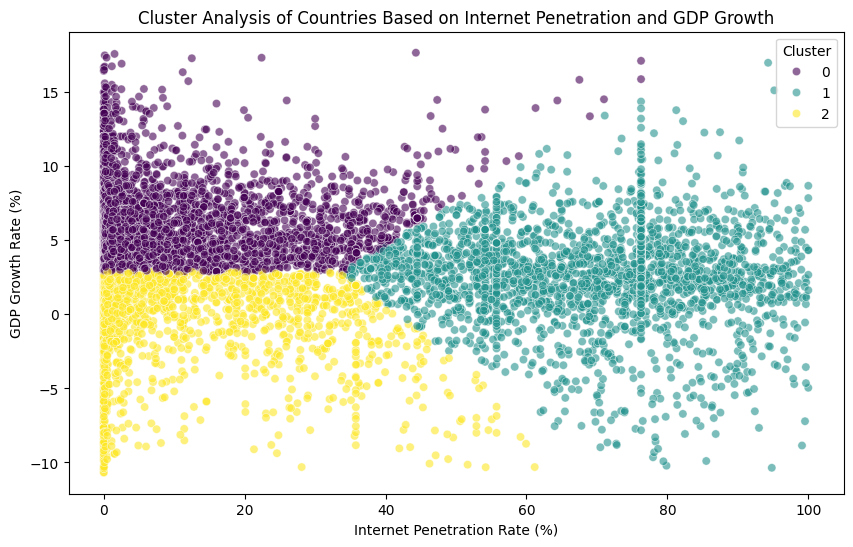

In [62]:
# Visualizing the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Internet Penetration Rate', y='GDP Growth', hue='Cluster', data=df_after1990, palette='viridis', alpha=0.6)
plt.title('Cluster Analysis of Countries Based on Internet Penetration and GDP Growth')
plt.xlabel('Internet Penetration Rate (%)')
plt.ylabel('GDP Growth Rate (%)')
plt.legend(title='Cluster')
plt.show()